## Classification of Radio Galaxies
In this python notebook, the classification of radio galaxies with the CAE networks is displayed under the strategy below.
1. Pre-training with non-labeled samples
2. Fine-tuning with labeled samples

[Note]: The script is modified and shall be pushed to our github repo. agn-ae.

In [1]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [2]:
import numpy as np

import sys
sys.setrecursionlimit(1000000)

In [3]:
from ConvAE_FT import ConvAE
import utils

## Pretraining 

In [4]:
# load data
import pickle
import time

X_raw = []
num_grp = 10
for i in range(num_grp):
    fname = '../data/sample-img-100-50-10-c3-gr{0}.pkl'.format(i)
    with open(fname, 'rb') as fp:
        datadict = pickle.load(fp)
        X_raw.append(datadict['data'])
    time.sleep(3)

In [5]:
# Combine and normalization
X_pre = np.vstack(X_raw)
del(X_raw)

In [6]:
# load labels
clspath = "../sample_agn.pkl"
with open(clspath, 'rb') as fp:
    clsdict = pickle.load(fp)
labels = np.zeros((len(X_pre),))
for i,c in enumerate(["0","1"]):
    print("label %s %d" % (c,i))
    for l in clsdict["labels"][c]:
        labels[range(l*num_grp,(l+1)*num_grp,1)] = i
# Extract samples of mulitple components
idx_agn = np.where(labels==1)[0]
labels_pre = labels[idx_agn]

label 0 0
label 1 1


In [7]:
# Reshape and generate train and test dataset
rs = 50
# normalization and whitening
X_train_pre = X_pre[idx_agn,:]
X_min = X_train_pre.min()
X_max = X_train_pre.max()
X_train_pre = (X_train_pre - X_min) / (X_max - X_min)
X_in = X_train_pre.reshape(-1,rs,rs,1)
X_mean = np.mean(X_train_pre)
X_w = X_in - X_mean # Whitening? 

# randomly select
idx = np.random.permutation(X_train_pre.shape[0])
numtrain = 140000
X_tr = X_w[idx[0:numtrain],:]
X_te = X_w[idx[numtrain:],:]

In [8]:
# Construct the network
numclass = 4
encode_nodes = 16
cae = ConvAE(input_shape=X_tr.shape, 
             kernel_size=[3,3,3,3], 
             kernel_num = [8,8,16,32],
             fc_nodes=[], encode_nodes=encode_nodes,
             padding=('SAME','SAME'),
             stride=(2,2),
             numclass = numclass)
cae.cae_build()
cae.cnn_build(learning_rate=0.001) # In order to init the weights

In [9]:
print(cae.shapes_en)
print(cae.shapes_de)

[[None, 50, 50, 1], [None, 25, 25, 8], [None, 13, 13, 8], [None, 7, 7, 16]]
[[None, 7, 7, 16], [None, 13, 13, 8], [None, 25, 25, 8], [None, 50, 50, 1]]


In [10]:
# train
num_epochs = 50
learning_rate = 0.001
batch_size = 100
cae.cae_train(data=X_tr, num_epochs=num_epochs, learning_rate=learning_rate, batch_size=batch_size)

[2017-09-05: 13:58:01] Training parameters

[2017-09-05: 13:58:01] Epochs: 50	Learning rate: 0.00

[2017-09-05: 13:58:01] Batch size: 100	Drop rate: 0.50

[2017-09-05: 13:58:07] Epoch: 001	Average loss: 0.004354
[2017-09-05: 13:58:11] Epoch: 002	Average loss: 0.002635
[2017-09-05: 13:58:15] Epoch: 003	Average loss: 0.002271
[2017-09-05: 13:58:20] Epoch: 004	Average loss: 0.002421
[2017-09-05: 13:58:24] Epoch: 005	Average loss: 0.002323
[2017-09-05: 13:58:29] Epoch: 006	Average loss: 0.001976
[2017-09-05: 13:58:33] Epoch: 007	Average loss: 0.002077
[2017-09-05: 13:58:38] Epoch: 008	Average loss: 0.002602
[2017-09-05: 13:58:42] Epoch: 009	Average loss: 0.001859
[2017-09-05: 13:58:47] Epoch: 010	Average loss: 0.002040
[2017-09-05: 13:58:51] Epoch: 011	Average loss: 0.001698
[2017-09-05: 13:58:56] Epoch: 012	Average loss: 0.002310
[2017-09-05: 13:59:00] Epoch: 013	Average loss: 0.002514
[2017-09-05: 13:59:05] Epoch: 014	Average loss: 0.002209
[2017-09-05: 13:59:09] Epoch: 015	Average loss:

In [11]:
# os.mkdir("result-170902")
# cae.cae_save(namepath="./result-170902/result-120-6-5layers.pkl",netpath="./result-170902/model-120-6-5layers")

(14, 50, 50, 1)


/home/mzx/.local/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


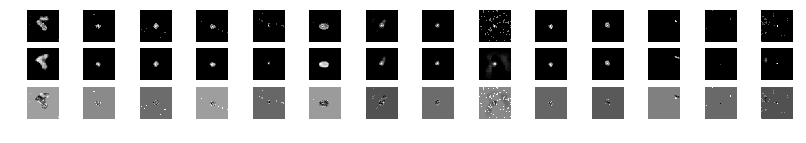

In [12]:
n_examples = 14
idx_n = np.random.permutation(len(X_te))
test_xs = X_te[idx_n[0:n_examples],:,:,:].astype('float32')

recon = cae.cae_test(img=test_xs)
print(recon.shape)

def gen_norm(img):
    return (img-img.min())/(img.max() - img.min())

fig, axs = plt.subplots(3, n_examples, figsize=(n_examples, 2))
for example_i in range(n_examples):
    # raw
    axs[0][example_i].imshow(
        np.reshape(test_xs[example_i, :], (rs, rs)), cmap='gray')
    axs[0][example_i].axis('off')
    # learned
    axs[1][example_i].imshow(
        np.reshape(
            np.reshape(recon[example_i, ...], (rs**2,)),
            (rs,rs)), cmap='gray')
    axs[1][example_i].axis('off')
    # residual
    norm_raw = gen_norm(np.reshape(test_xs[example_i, :], (rs, rs)))
    norm_est = gen_norm(np.reshape(np.reshape(recon[example_i, ...], (rs**2,)),(rs, rs)))
    axs[2][example_i].imshow(norm_raw - norm_est, cmap='gray')
    axs[2][example_i].axis('off')

fig.show()
plt.draw()

/home/mzx/.local/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


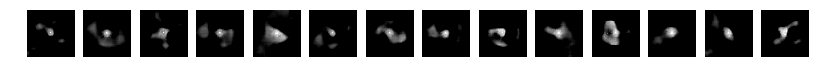

In [13]:
code = np.random.uniform(low=2.0, high=7.0, size=(n_examples,16)).astype('float32')
# img_de = cae.sess.run(cae.l_de, feed_dict={cae.l_in: None, cae.l_en: code, cae.droprate: 0.0})
img_de = cae.cae_decode(code)
fig, axs = plt.subplots(1, n_examples,figsize=(14,1))
for example_i in range(n_examples):
    # learned
    axs[example_i].imshow(
        np.reshape(
            np.reshape(img_de[example_i, ...], (rs**2,)),
            (rs, rs)), cmap='gray')
    axs[example_i].axis('off')

fig.show()
plt.draw()

In [14]:
n_examples = 3000
test_xs = X_te[0:n_examples]
code = cae.cae_encode(img=test_xs)

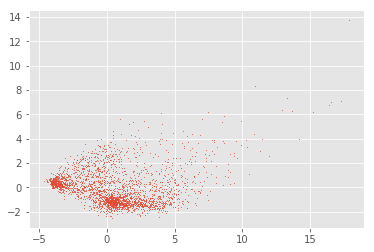

In [15]:
# PCA
# X_pca = PCA().fit_transform(code)
X_pca = utils.down_dimension(code=code, method='PCA')
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=0.2)
# plt.colorbar()
plt.show()

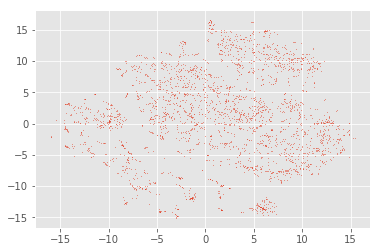

In [16]:
X_tsne = utils.down_dimension(code=code, method='tSNE', params={'n_components': 4, 'learning_rate': 100})
# X_tsne = TSNE(n_components=4,learning_rate=100).fit_transform(code)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1],s=0.1)
# plt.colorbar()
plt.show()

## Fine-tuning with labelled samples

In [17]:
with open("../sample-img-50.pkl", 'rb') as fp:
    sample_dict = pickle.load(fp)
sample_mat = sample_dict['data']
# sample_list = sample_dict['name']
labels_cnn = sample_dict['label'] - 1

In [18]:
# X_max = sample_mat.max()
# X_min = sample_mat.min()
X_train_cnn = (sample_mat - X_min) / (X_max - X_min)
# X_norm = sample_mat
X_w_cnn = X_train_cnn - X_mean
X_tr_cnn = X_w_cnn.reshape(-1, rs, rs, 1).astype('float32')

In [19]:
idx = np.random.permutation(len(labels_cnn))
numsamples = 25000
X_in = X_tr_cnn[idx[0:numsamples],:,:,:]
# get labels
X_out = labels_cnn[idx[0:numsamples]].astype('int32')

In [20]:
def vec2onehot(label,numclass):
    label_onehot = np.zeros((len(label),numclass))
    for i,l in enumerate(label):
        label_onehot[i, int(l)] = 1
    
    return label_onehot

In [21]:
X_out_onehot = vec2onehot(label=X_out, numclass=numclass)

In [22]:
# train
cae.numclass = numclass
num_epochs = 50
learning_rate = 0.001
batch_size = 100
cae.cnn_train(data=X_in, label=X_out_onehot, num_epochs=num_epochs, learning_rate=learning_rate, batch_size=batch_size)
# cae.cae_train(data=X_in, num_epochs=num_epochs, learning_rate=learning_rate, batch_size=batch_size)

[2017-09-05: 14:02:30] Training parameters

[2017-09-05: 14:02:30] Epochs: 50	Learning rate: 0.00

[2017-09-05: 14:02:30] Batch size: 100	Drop rate: 0.50

[2017-09-05: 14:02:31] Epoch: 001	Average loss: 1.049630
[2017-09-05: 14:02:31] Epoch: 002	Average loss: 1.044362
[2017-09-05: 14:02:32] Epoch: 003	Average loss: 1.071260
[2017-09-05: 14:02:33] Epoch: 004	Average loss: 1.068615
[2017-09-05: 14:02:33] Epoch: 005	Average loss: 1.033554
[2017-09-05: 14:02:34] Epoch: 006	Average loss: 0.988337
[2017-09-05: 14:02:35] Epoch: 007	Average loss: 1.066389
[2017-09-05: 14:02:35] Epoch: 008	Average loss: 1.089272
[2017-09-05: 14:02:36] Epoch: 009	Average loss: 0.912155
[2017-09-05: 14:02:36] Epoch: 010	Average loss: 0.914835
[2017-09-05: 14:02:37] Epoch: 011	Average loss: 0.847329
[2017-09-05: 14:02:38] Epoch: 012	Average loss: 0.901214
[2017-09-05: 14:02:38] Epoch: 013	Average loss: 0.919351
[2017-09-05: 14:02:39] Epoch: 014	Average loss: 0.897881
[2017-09-05: 14:02:40] Epoch: 015	Average loss:

In [23]:
test_xs = X_tr_cnn[idx[numsamples:],:,:,:]
# get labels
test_label = labels_cnn[idx[numsamples:]].astype('int32')
code = cae.cae_encode(img=test_xs)

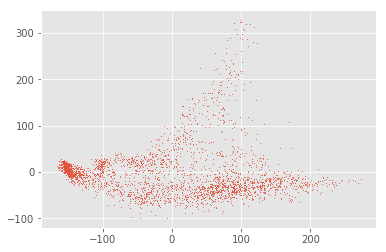

In [24]:
# PCA
# X_pca = PCA().fit_transform(code)
X_pca = utils.down_dimension(code=code, method='PCA')
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=0.2)
# plt.colorbar()
plt.show()

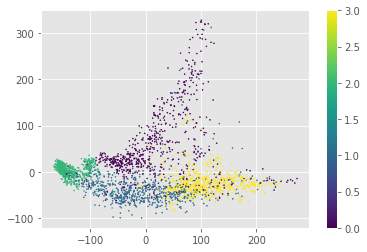

In [25]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=test_label, s=1)
plt.colorbar()
plt.show()

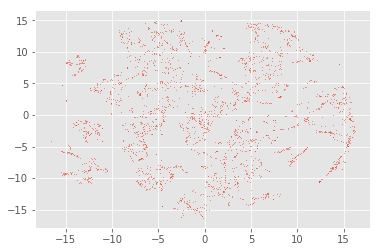

In [26]:
X_tsne = utils.down_dimension(code=code, method='tSNE', params={'n_components': 4, 'learning_rate': 100})
# X_tsne = TSNE(n_components=4,learning_rate=100).fit_transform(code)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1],s=0.1)
# plt.colorbar()
plt.show()

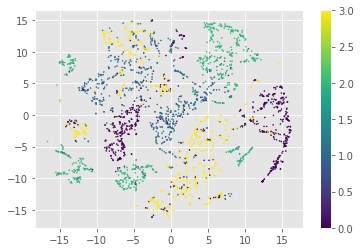

In [27]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=test_label, s=1)
plt.colorbar()
plt.show()

(14, 50, 50, 1)


/home/mzx/.local/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


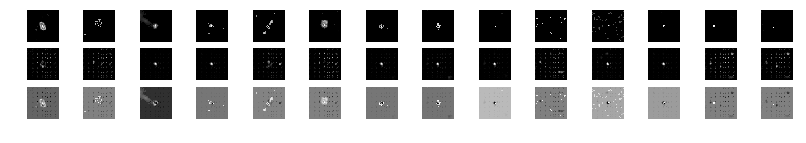

In [28]:
n_examples = 14
idx_n = np.random.permutation(len(X_te))
test_xs = X_te[idx_n[0:n_examples],:,:,:].astype('float32')

recon = cae.cae_test(img=test_xs)
print(recon.shape)

def gen_norm(img):
    return (img-img.min())/(img.max() - img.min())

fig, axs = plt.subplots(3, n_examples, figsize=(n_examples, 2))
for example_i in range(n_examples):
    # raw
    axs[0][example_i].imshow(
        np.reshape(test_xs[example_i, :], (rs, rs)), cmap='gray')
    axs[0][example_i].axis('off')
    # learned
    axs[1][example_i].imshow(
        np.reshape(
            np.reshape(recon[example_i, ...], (rs**2,)),
            (rs,rs)), cmap='gray')
    axs[1][example_i].axis('off')
    # residual
    norm_raw = gen_norm(np.reshape(test_xs[example_i, :], (rs, rs)))
    norm_est = gen_norm(np.reshape(np.reshape(recon[example_i, ...], (rs**2,)),(rs, rs)))
    axs[2][example_i].imshow(norm_raw - norm_est, cmap='gray')
    axs[2][example_i].axis('off')

fig.show()
plt.draw()

/home/mzx/.local/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


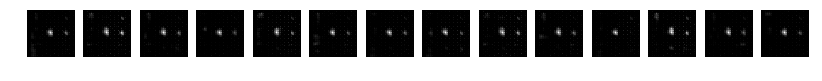

In [29]:
n_examples = 14
code = np.random.uniform(low=2.0, high=7.0, size=(n_examples,16)).astype('float32')
# img_de = cae.sess.run(cae.l_de, feed_dict={cae.l_in: None, cae.l_en: code, cae.droprate: 0.0})
img_de = cae.cae_decode(code)
fig, axs = plt.subplots(1, n_examples,figsize=(14,1))
for example_i in range(n_examples):
    # learned
    axs[example_i].imshow(
        np.reshape(
            np.reshape(img_de[example_i, ...], (rs**2,)),
            (rs, rs)), cmap='gray')
    axs[example_i].axis('off')

fig.show()
plt.draw()